In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
from bs4 import BeautifulSoup # documentation available at : www.crummy.com/software/BeautifulSoup/bs4/doc/
import requests # sends http requests and access the page : docs.python-requests.org/en/latest/
import csv # creates the output csv file
#import unicodedata # works with string encoding of the data

In [4]:
entries = []
entry = []
urlnumber = 2 # Give the page number to start with


while urlnumber < 110: # Give the page number to end with

    url = 'http://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p%d' % (urlnumber,) # Give the url of the forum, excluding the page number in the hyperlink

    try:
        r = requests.get(url, timeout = 10) # Sending a request to access the page
    except Exception as e:
        print("Error message:",e)
        break;

    data = r.text
    
    soup = BeautifulSoup(data, 'lxml') # Getting the page source into the soup
    
    for div in soup.find_all('div'):
        entry = []
        if(div.get('class') != None and div.get('class')[0] == 'Comment'): # A single post is referred to as a comment. Each comment is a block denoted in a div tag which has a class called comment.
            ps = div.find_all('p') # gets all the tags called p to a variable ps
            aas = div.find_all('a') # gets all the tags called a to a variable aas
            spans = div.find_all('span')
            times = div.find_all('time') # used to extract the time tag which gives the iDate of the post

            concat_str = ''
            for str in aas[1].contents: # prints the contents that is between the tag start and end
                if str != "<br>" or str != "<br/>": # breaks in post which we need to work around
                    concat_str = (concat_str + ' '+ str).encode("utf-8").strip() # the format extracted is a unicode - we need a uniform structure to work with the strings
            entry.append(concat_str)

            concat_str = ''
            for str in times[0].contents:
                if str != "<br>" or str != "<br/>":
                    concat_str = (concat_str + ' '+ str).encode('iso-8859-1').strip()
            entry.append(concat_str)

            for div in div.find_all('div'):
                if (div.get('class') != None and div.get('class')[0] == 'Message'): # extracting the div tag with the class attribute as message
                    blockquotes = []
                    x = div.get_text()
                    for bl in div.find_all('blockquote'):
                        blockquotes.append(bl.get_text()) # block quote is used to get the quote made by a person. get_text helps to eliminate the hyperlinks and pulls out only the data.
                        bl.decompose()
                    # Encoding the text to ascii code by replacing the non-ascii characters
                    ascii_encoding = div.get_text().replace("\n"," ").replace("<br/>","").encode('ascii','replace')
                    # Convert the ASCII encoding to Latin1 encoding
                    latin1_encoding = ascii_encoding.decode('ascii').encode('iso-8859-1')
                    # Append the encoding bytes to output list
                    entry.append(latin1_encoding)

                    for bl in blockquotes:
                        ascii_encoding = bl.replace("\n"," ").replace("<br/>","").encode('ascii','replace')
                        latin1_encoding = ascii_encoding.decode('ascii').encode('iso-8859-1')
                        entry.append(latin1_encoding)

            entries.append(entry)
            
    urlnumber += 1

# Convert a list of byte to list a of string     
stringlist=[[x.decode('iso-8859-1') for x in entry] for entry in entries]
# Save the list to a csv file
with open('edmunds_extraction.csv', 'w') as output:
    writer = csv.writer(output, quoting=csv.QUOTE_ALL)
    writer.writerows(stringlist)

print ("Wrote to edmunds_extraction.csv")

Wrote to edmunds_extraction.csv


### Task A: Identify top 10 brands by frequency. From the posts, calculate lift ratios for associations between the brands. You will have to write a script to do this task. Show the brands on a multidimensional scaling (MDS) map. 

In [5]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import MDS
import re

In [6]:
import spacy
import spacy.cli?
# spacy.cli.download("en_core_web_sm")
from spacy.lang.en import stop_words

In [7]:
import os
os.chdir(r'/Users/yanhuanhuang/Desktop/MMA/INSY669-Text Analytics/Group Project')

In [8]:
# Documents
documents = pd.read_csv('edmunds_extraction.csv', header=None)

In [9]:
documents

,0,1,2
0,wishnhigh1,April 2002,The problem is that they are HUGE generalizat...
1,kd6aw1,April 2002,Have found out that with some of the more pow...
2,fwatson,April 2002,How does your theory explain English cars? A ...
3,dave330i,April 2002,"""Being that it is an automatic I can enjoy my..."
4,blueguydotcom,April 2002,"He did mention ""in rush hour traffic."" Like t..."
...,...,...,...
5395,qbrozen,August 2006,will of course vary greatly depending on wher...
5396,habitat1,August 2006,Yes. in 2003 I bought my 330i ZHP off a lot.....
5397,blueguydotcom,August 2006,"No, I bought my ZHP off the lot in 2003 - I p..."
5398,habitat1,August 2006,"No, I bought my ZHP off the lot in 2003 - I p..."


In [10]:
column_names = ["users", "time", "txt"]

In [11]:
documents.columns = column_names
documents

,users,time,txt
0,wishnhigh1,April 2002,The problem is that they are HUGE generalizat...
1,kd6aw1,April 2002,Have found out that with some of the more pow...
2,fwatson,April 2002,How does your theory explain English cars? A ...
3,dave330i,April 2002,"""Being that it is an automatic I can enjoy my..."
4,blueguydotcom,April 2002,"He did mention ""in rush hour traffic."" Like t..."
...,...,...,...
5395,qbrozen,August 2006,will of course vary greatly depending on wher...
5396,habitat1,August 2006,Yes. in 2003 I bought my 330i ZHP off a lot.....
5397,blueguydotcom,August 2006,"No, I bought my ZHP off the lot in 2003 - I p..."
5398,habitat1,August 2006,"No, I bought my ZHP off the lot in 2003 - I p..."


In [12]:
# Clean Text
nlp = spacy.load('en_core_web_sm')
def clean_text(x): # x is a document
    # conver to lower case 
    x = x.lower()
    # remove new line
    x = re.sub(r'\n', ' ', x)
    # remove link
    x = re.sub(r"https?://[^\s]+", "", x)
    # remove name twitter tag
    x = re.sub(r'@[A-Za-z0-9\_]+', ' ', x) 
    # remove name hashtag tag
    x = re.sub(r'\#[A-Za-z0-9\_]+', ' ', x) 
    # remove specific word - southwest OR airline
    x = re.sub('southwest|airline', ' ', x)
    # lemmatization
    x = ' '.join([token.lemma_ for token in nlp(x)])
    # remove multiple space
    x = re.sub(r' +', ' ', x)
    # remove space before and after the text
    x = x.strip()
    return x

In [13]:
# Convert documents into a list
all_documents = documents['txt'].tolist()

In [23]:
#all_documents

In [15]:
# Initialize the CountVectorizer to transform the text data into a bag-of-words model only for the top 10 most frequent brands, do the MDS for those words
vectorizer = CountVectorizer(brands=list(stop_words.STOP_WORDS), # stopwords in NLTK is more complete than Sklearn, https://gist.github.com/sebleier/554280
                             max_features=10, # include only the top 10 words
                             preprocessor=clean_text,
                             token_pattern='[a-zA-Z0-9]{3,}') # include words with more than 3 characters 

In [16]:
# Transform the documents into a document-term matrix
dtm = vectorizer.fit_transform(all_documents)

In [17]:
# Extract feature names (non-stopwords)
feature_names = vectorizer.get_feature_names_out()
# create an array that represent document by terms

In [18]:
# Convert the document-term matrix to a dense array
dtm_array = dtm.toarray()

In [19]:
# Calculate lift between terms
term_lift = np.dot(dtm_array.T, dtm_array)
term_occurrence = np.sum(dtm_array, axis=0)
# + 1e-8 is added to avoid division by zero
lift_matrix = term_lift / (np.outer(term_occurrence, term_occurrence) + 1e-8)

In [20]:
# Calculate dissimilarity matrix based on lift
dissimilarity_matrix = 1 / lift_matrix
print(dissimilarity_matrix)

[[ 844.55764625 2832.73565077 2627.39447732 2559.10603589 2627.15617334
  2821.91266913 2621.87354086 2448.29252438 2867.70940171 2861.96460177]
 [2832.73565077 1477.6761735  2463.21185475 3260.21083455 2209.09857108
  2701.37287433 2981.91893998 3047.61805226 3181.08587786 2833.64421998]
 [2627.39447732 2463.21185475  928.68281654 2786.81152263 2669.36720554
  2391.05263158 2590.18165628 2780.8050171  3348.33025099 2782.02753623]
 [2559.10603589 3260.21083455 2786.81152263  557.8466704  2908.47863248
  2766.39468691 2314.53513514 2740.46564885 1739.49184149 2733.50906892]
 [2627.15617334 2209.09857108 2669.36720554 2908.47863248  697.43695797
  2596.51304348 2363.8787062  3142.26923077 2773.90562613 2673.26327945]
 [2821.91266913 2701.37287433 2391.05263158 2766.39468691 2596.51304348
   995.15169195 1804.64337176 2648.30390921 3228.8535503  2933.50931677]
 [2621.87354086 2981.91893998 2590.18165628 2314.53513514 2363.8787062
  1804.64337176  573.6331384  1980.13001605 2584.96169355 2

In [21]:
# Apply MDS to reduce dimensionality to 2D
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42) 
# create two components for each of the feature/word we have
mds_result = mds.fit_transform(dissimilarity_matrix)

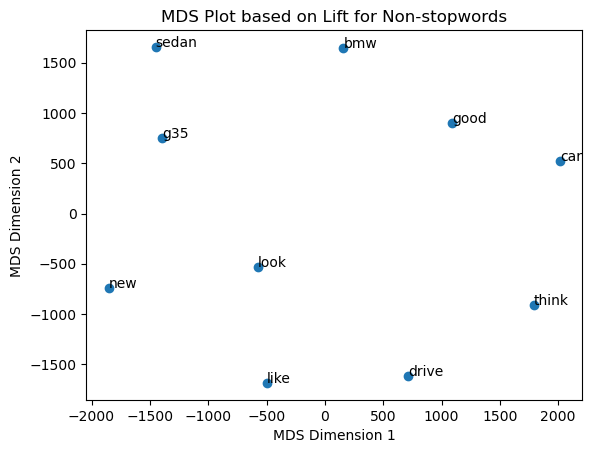

In [22]:
# Plot the MDS result
plt.scatter(mds_result[:, 0], mds_result[:, 1])

# Annotate points with feature names
for i, txt in enumerate(feature_names):
    plt.annotate(txt, (mds_result[i, 0], mds_result[i, 1]))

plt.title('MDS Plot based on Lift for Non-stopwords')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.show()